### Bert loading

In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

model_name = "bert-base-uncased"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.load_state_dict(torch.load("/kaggle/working/bert_sst2.pth"))

model.eval()

tokenizer = BertTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() 

print("Model loaded successfully!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!


In [ ]:
# class0==neg
#class 1==pos

# Gradient x Input

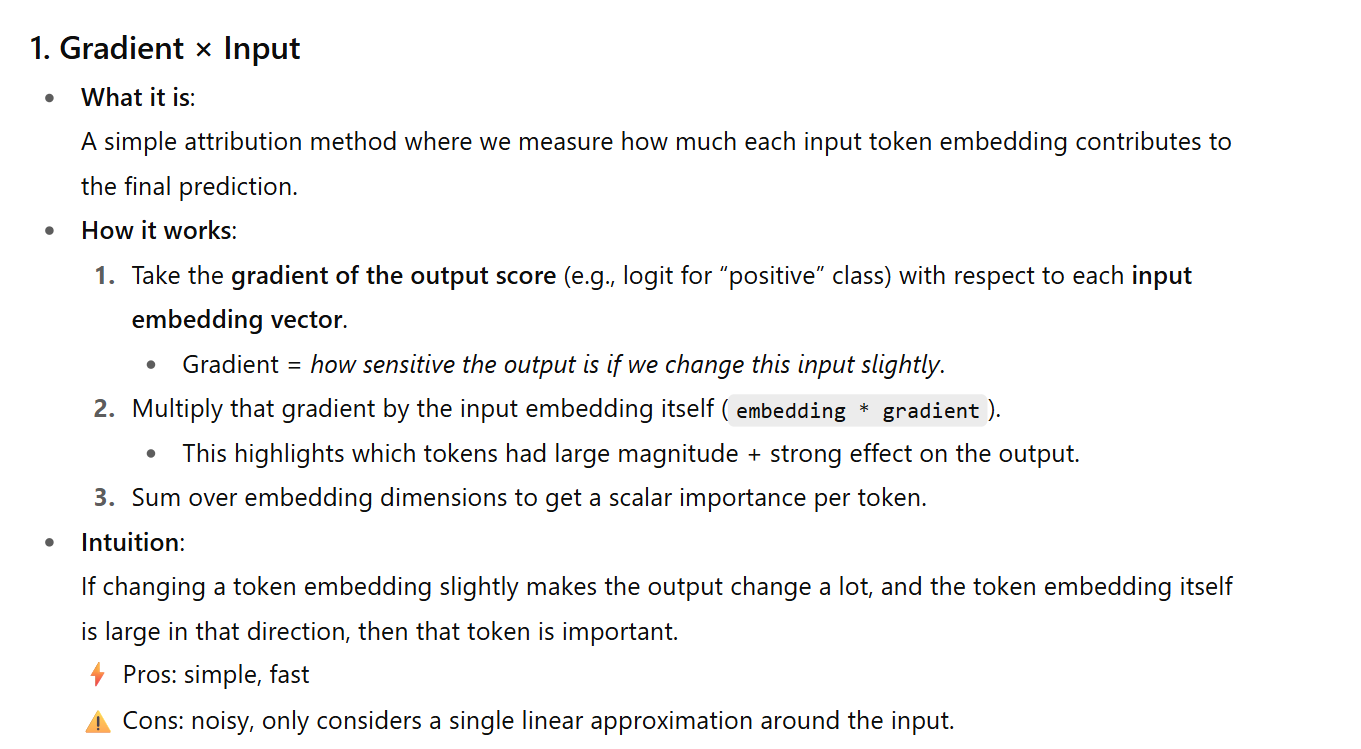

Gradient x Input is  a way to mesure how seneitve the output is to each input embedding , it is an  attribution method

the gradient is  How sensitive the output is to changes in each input dimension
the input is the actual embedding value of the tokens to bert

In [23]:
#we tokenize the input test
sentence ="This movie is good"
inputs = tokenizer(sentence, return_tensors="pt") 
input_ids = inputs["input_ids"]
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)
input_ids  # we convert each word to the toekn id 


tensor([[ 101, 2023, 3185, 2003, 2204,  102]], device='cuda:0')

In [40]:
#we get embedding of each token
embeddings = model.bert.embeddings.word_embeddings(input_ids)
embeddings = embeddings.to(device)
print(embeddings)
print(embeddings.shape)

tensor([[[ 0.0140, -0.0266, -0.0238,  ...,  0.0086,  0.0070,  0.0154],
         [-0.0566,  0.0144, -0.0042,  ..., -0.0034,  0.0009,  0.0100],
         [-0.0022, -0.0080, -0.0245,  ..., -0.0217,  0.0071, -0.0522],
         [-0.0350, -0.0249, -0.0256,  ...,  0.0017, -0.0012,  0.0267],
         [ 0.0010, -0.0088, -0.0377,  ..., -0.0695, -0.0800, -0.0870],
         [-0.0144, -0.0104,  0.0059,  ..., -0.0247,  0.0030, -0.0014]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)
torch.Size([1, 6, 768])


why 6 ?
the sentence has 4 words , the 6 tokens are 
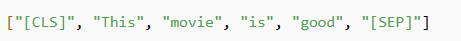

Token count ≠ word count


In [47]:
embeddings=embeddings.detach().requires_grad_(True)  #why ? cause later we would need 
#the gradient of the embeddigns to see their contribution later to 
#the final result

### Forward pass through the model :We compute the output logit for the class of interest:

In [48]:
outputs = model(inputs_embeds=embeddings, attention_mask=inputs["attention_mask"])
logits = outputs.logits

In [49]:
score = logits[0, 1]
score

tensor(3.5083, device='cuda:0', grad_fn=<SelectBackward0>)

### Backward to get gradients :Compute the gradient of the score w.r.t each input embedding:

In [50]:
score.backward() 
grads = embeddings.grad

In [51]:
print(grads)

tensor([[[-0.0674, -0.0791,  0.0433,  ..., -0.0037, -0.0552, -0.0368],
         [ 0.0116, -0.2438,  0.1734,  ..., -0.1712,  0.0240, -0.0363],
         [ 0.0184,  0.0419,  0.1199,  ..., -0.3073, -0.1059, -0.3543],
         [ 0.1536, -0.1327,  0.2381,  ..., -0.1656,  0.0300,  0.0246],
         [ 0.3988, -0.2827, -0.1472,  ..., -0.0425, -0.2251, -0.0625],
         [ 0.0406, -0.2181,  0.1298,  ..., -0.1503, -0.0712,  0.1125]]],
       device='cuda:0')


### Multiply gradient by embedding : This gives the token-level contribution vector:

In [52]:
grad_times_input = grads * embeddings

In [53]:
token_importance = grad_times_input.sum(dim=-1)

# Visualisation

### Score for class 0 (negative sentiment)

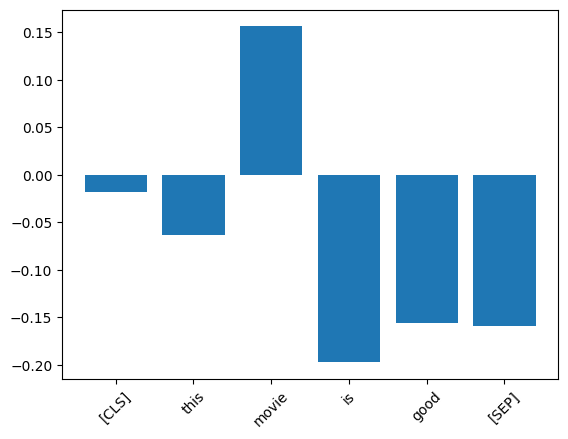

In [ ]:

scores = token_importance[0].detach().cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

plt.bar(tokens, scores)
plt.xticks(rotation=45)
plt.show()


Here we are working on the negatvie class , the negative magnitudes are pushing in the opposite class (the pos meaning )
which explains why good has the highest magnitude

##  Comparative Bar Chart (Both Classes)

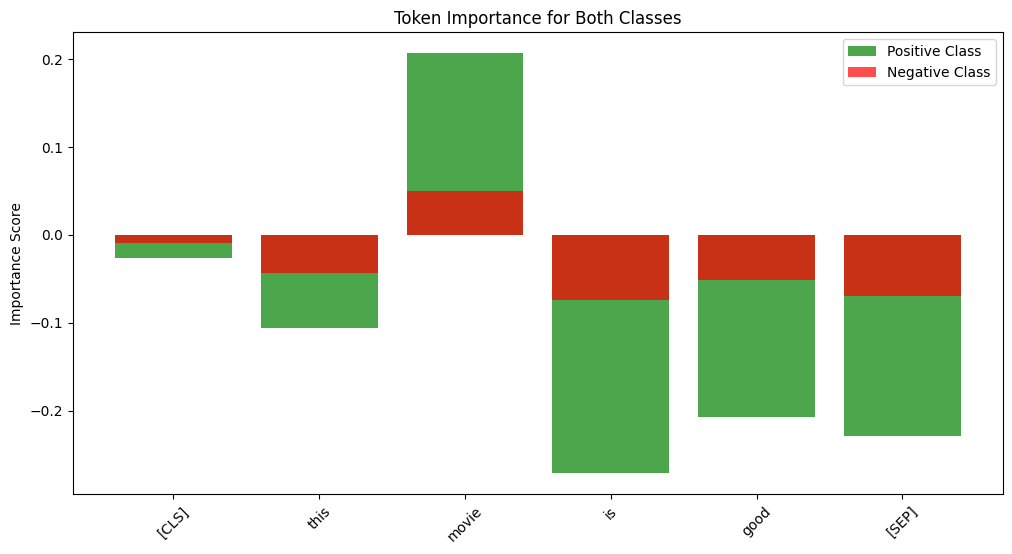

In [ ]:
# Get importance scores for both classes
outputs = model(inputs_embeds=embeddings, attention_mask=inputs["attention_mask"])
logits = outputs.logits

# importance for class 0 
model.zero_grad()
score_neg = logits[0, 0]
score_neg.backward(retain_graph=True)
grads_neg = embeddings.grad
importance_neg = (grads_neg * embeddings).sum(dim=-1)[0].detach().cpu().numpy()
#importance for class 1
model.zero_grad()
score_pos = logits[0, 1] 
score_pos.backward()
grads_pos = embeddings.grad
importance_pos = (grads_pos * embeddings).sum(dim=-1)[0].detach().cpu().numpy()

# comparative plot
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
x = range(len(tokens))

plt.figure(figsize=(12, 6))
plt.bar(x, importance_pos, alpha=0.7, label='Positive Class', color='green')
plt.bar(x, importance_neg, alpha=0.7, label='Negative Class', color='red')
plt.xticks(x, tokens, rotation=45)
plt.legend()
plt.title('Token Importance for Both Classes')
plt.ylabel('Importance Score')
plt.show()

why is has so much pos meaning?  is this fault just in this pipeline or sth that is more general

##  Heatmap (Token × Dimension Importance)

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


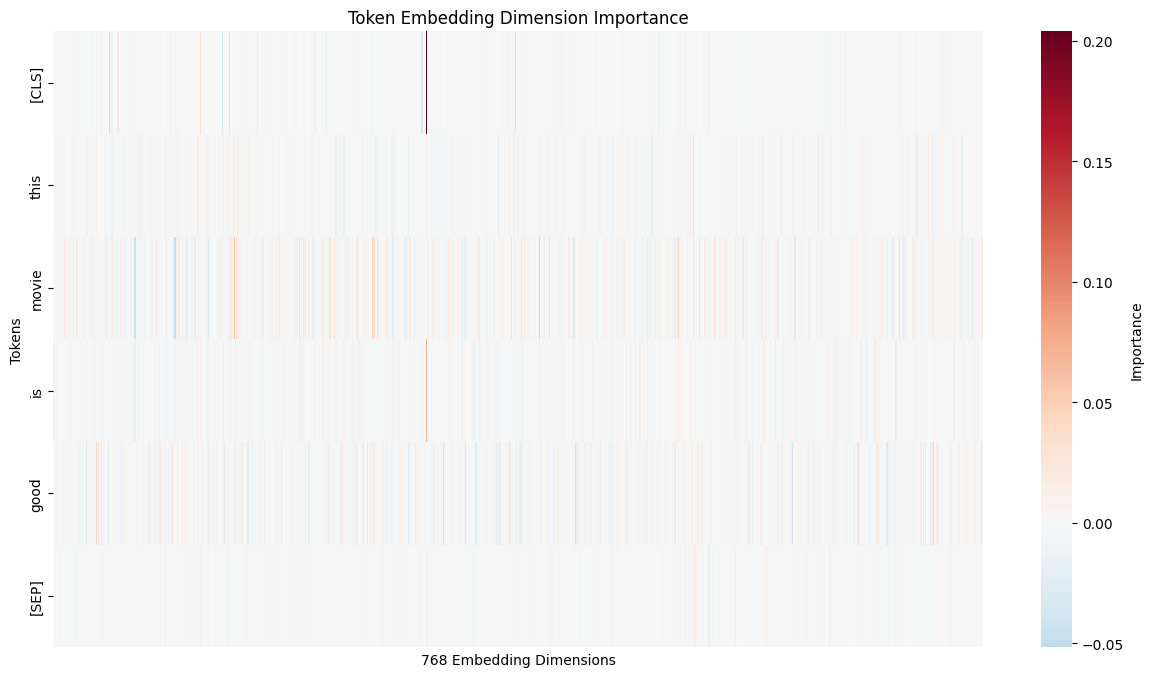

In [ ]:
# the gradient × input matrix (before summing)
grad_times_input = grads * embeddings
importance_matrix = grad_times_input[0].detach().cpu().numpy()

plt.figure(figsize=(15, 8))
sns.heatmap(importance_matrix, 
            xticklabels=False, 
            yticklabels=tokens,
            cmap='RdBu_r', 
            center=0,
            cbar_kws={'label': 'Importance'})
plt.title('Token Embedding Dimension Importance')
plt.xlabel('768 Embedding Dimensions')
plt.ylabel('Tokens')
plt.show()

## Side-by-Side Class Comparison

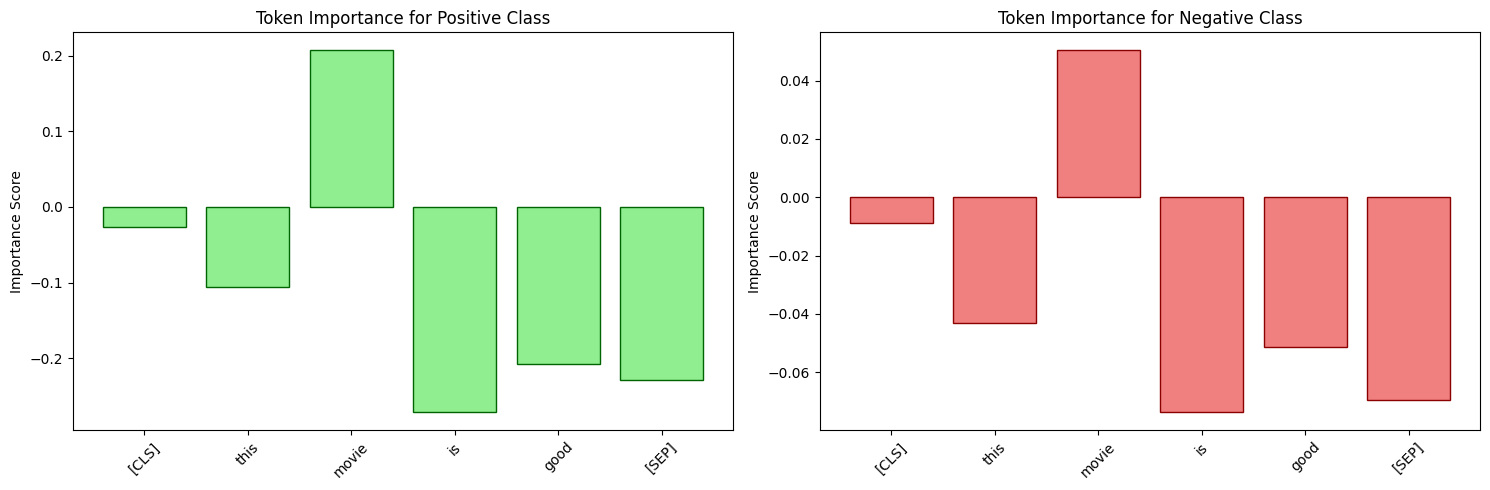

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# positive class
ax1.bar(tokens, importance_pos, color='lightgreen', edgecolor='darkgreen')
ax1.set_title('Token Importance for Positive Class')
ax1.set_ylabel('Importance Score')
ax1.tick_params(axis='x', rotation=45)

# negative class  
ax2.bar(tokens, importance_neg, color='lightcoral', edgecolor='darkred')
ax2.set_title('Token Importance for Negative Class')
ax2.set_ylabel('Importance Score')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Confidence Score Breakdown

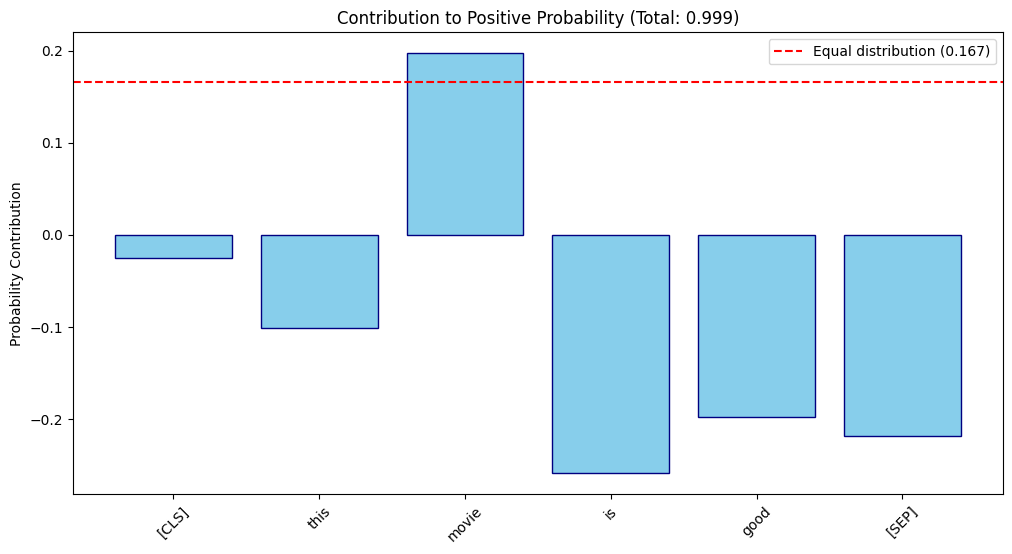

In [ ]:
# show how each token contributes to the final confidence
probabilities = torch.softmax(logits, dim=-1)[0].detach().cpu().numpy()
pos_prob = probabilities[1]

total_importance = np.sum(np.abs(importance_pos))
normalized_contributions = (importance_pos / total_importance) * pos_prob

plt.figure(figsize=(12, 6))
plt.bar(tokens, normalized_contributions, color='skyblue', edgecolor='navy')
plt.axhline(y=pos_prob/len(tokens), color='red', linestyle='--', 
            label=f'Equal distribution ({pos_prob/len(tokens):.3f})')
plt.title(f'Contribution to Positive Probability (Total: {pos_prob:.3f})')
plt.ylabel('Probability Contribution')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Statistical Summary Visualization

Top influential tokens:
   token  importance_pos  importance_neg  net_importance  abs_importance
3     is       -0.271341       -0.073753       -0.197587        0.345094
5  [SEP]       -0.228919       -0.069746       -0.159173        0.298664
4   good       -0.207651       -0.051342       -0.156309        0.258993
2  movie        0.206775        0.050395        0.156380        0.257170
1   this       -0.105935       -0.043038       -0.062897        0.148973
0  [CLS]       -0.026553       -0.008980       -0.017572        0.035533


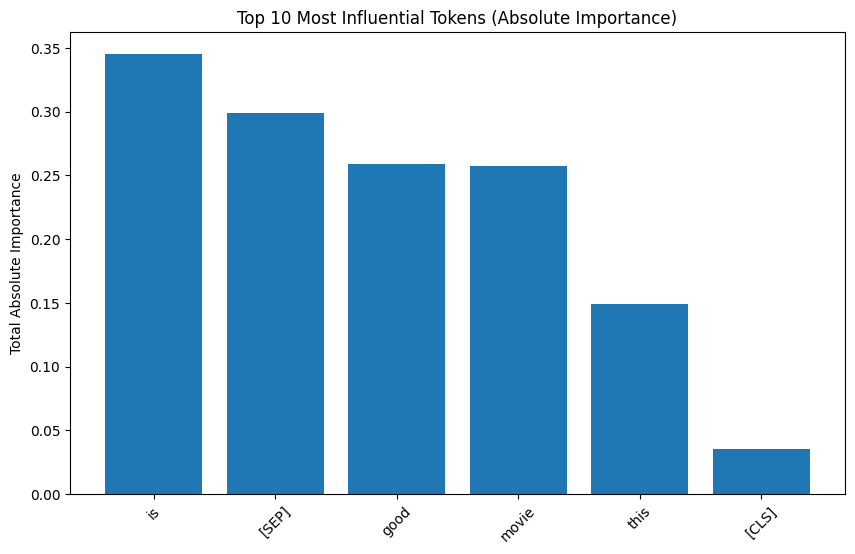

In [ ]:

importance_df = pd.DataFrame({
    'token': tokens,
    'importance_pos': importance_pos,
    'importance_neg': importance_neg,
    'net_importance': importance_pos - importance_neg,
    'abs_importance': np.abs(importance_pos) + np.abs(importance_neg)
})

# sort by absolute importance
importance_df = importance_df.sort_values('abs_importance', ascending=False)

print("Top influential tokens:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.bar(importance_df['token'][:10], importance_df['abs_importance'][:10])
plt.title('Top 10 Most Influential Tokens (Absolute Importance)')
plt.xticks(rotation=45)
plt.ylabel('Total Absolute Importance')
plt.show()